#Supervised Acoustic Word Embeddings

Sequence to sequence model. Input: spoken word segments. Output: character or phoneme sequence. Encoder output is used as acoustic word embedding. The following script includes both training and ABX evaluation code. To run the code, you need to modify the "Hyperparameters" block and specify input files:


*   **train_file** : audio segments corresponding to words. Should be processed as sequences of feature vectors (e.g. MFCC vectors)
*   **test_file**: audio segments similar in format to train_file. 
*   **phoneme_file**: list of words corresponding to the training segments. The words could be sequences of characters or phonemes. 
*   **words_file**: list of words corresponding to the test segments. The words should be sequences of characters. 
*   **speakers_file**: list of speaker ids corresponding to the test segments. These are needed for extracting ABX pairs. 



In [ ]:
!pip install Levenshtein


from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from tqdm.notebook  import tqdm
import random
import numpy as np
from random import randint

from torch.nn.utils.rnn import pad_sequence
from sklearn.cluster import MiniBatchKMeans as KMeans
from sklearn.metrics import adjusted_rand_score, homogeneity_score, completeness_score, v_measure_score
from collections import Counter
from google.colab import drive
import math
from Levenshtein import distance
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import pdist, squareform
from matplotlib import pyplot as plt


drive.mount('/content/gdrive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 258 kB 4.2 MB/s 
     |████████████████████████████████| 1.8 MB 64.0 MB/s 
     |████████████████████████████████| 101 kB 14.8 MB/s 
Mounted at /content/gdrive


#Model: 

In [ ]:
def length_to_mask(length, max_len=None, dtype=None):

    assert len(length.shape) == 1, 'Length shape should be 1 dimensional.'
    max_len = max_len or length.max().item()
    mask = torch.arange(max_len, device=length.device,
                        dtype=length.dtype).expand(len(length), max_len) < length.unsqueeze(1)
    if dtype is not None:
        mask = torch.as_tensor(mask, dtype=dtype, device=length.device)
    return mask


class Encoder(nn.Module):
    def __init__(self, input_dim,  hid_dim=100, n_layers=2, dropout=0.3):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.hid_dim = hid_dim
        self.n_layers = n_layers   
        self.device = torch.device("cuda")    
        self.rnn = nn.LSTM(input_dim, hid_dim, n_layers, bidirectional=True, batch_first = True)
        
    def forward(self, src, src_len):
        packed_src = nn.utils.rnn.pack_padded_sequence(self.dropout(src), src_len.to('cpu'), enforce_sorted=True, batch_first=True )
        outputs, (hidden, cell)= self.rnn(packed_src, None)
        return hidden[self.n_layers*2-2:] 

class Decoder(nn.Module):
    def __init__(self, output_dim, hid_dim=100, n_layers=2):
        super().__init__()
        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.emb = nn.Embedding(output_dim, 50)
        self.input_dim = 50+hid_dim*2
        self.rnn = nn.LSTM(self.input_dim, self.hid_dim, n_layers, bidirectional=False, batch_first = True)
        self.fc_out = nn.Linear(self.hid_dim, self.output_dim)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input, hidden, hidden_enc):
        emb=self.emb(input).unsqueeze(1)
        rnn_input=torch.cat((emb, hidden_enc), dim=2)
        output, hidden = self.rnn(rnn_input, hidden)     
        prediction = self.softmax(self.fc_out(output.squeeze(1)))        
        return prediction, hidden

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()       
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, src, trg, src_len, trg_len, epoch=0):    
        batch_size = src.shape[0]
        decoder_hidden_size = self.decoder.hid_dim
        hidden_enc = self.encoder(src, src_len)
        hidden_enc = torch.cat((hidden_enc[0],hidden_enc[1]), dim=1).unsqueeze(1)
        len=trg.shape[1]  
        outputs = torch.zeros(batch_size, len, self.decoder.output_dim).to(self.device)
        _input = torch.zeros(batch_size, dtype=torch.int32)
        output, hidden = self.decoder(_input.to(self.device), None, hidden_enc)
        outputs[:,0,:] = output.squeeze(1)
        for t in range(1, len):
            prev_output = output.detach().unsqueeze(1)
            topv, topi = prev_output.topk(1)
            input = topi.squeeze()
            output, hidden = self.decoder(input, hidden, hidden_enc) 
            outputs[:,t,:] = output.squeeze(1)  
        mask = length_to_mask(torch.LongTensor(trg_len).to(self.device))
        outputs = outputs * mask.unsqueeze(2)
        return outputs



#Hyperparameters:


In [ ]:
#Change the following as needed

#MFCC features:
input_dim = 1024

#train and test files: should contain segmented words represented as variable-length sequence of features
train_file='/content/gdrive/My Drive/dev-clean-mfcc.pt'
test_file='/content/gdrive/My Drive/test-clean-mfcc.pt'
model_save_dir = "/content/gdrive/My Drive/supervised_model_mfcc.pt"

phoneme_file = '/content/gdrive/My Drive/dev-words.pt' #list of words corresponding to each segment in train_file; chars or phonemes can be used here
words_file='/content/gdrive/My Drive/test-words.pt' #list of words corresponding to each segment in test_file
speakers_file = '/content/gdrive/My Drive/test-speakers.pt' #list of speaker ids corresponding to each word in test file

encoder_input_dim = input_dim  
decoder_hidden_dim = 250
encoder_hidden_dim = 150
decoder_output_dim = input_dim
BATCH_SIZE = 512
device = torch.device("cuda")


class AudioWordsDataset(Dataset):
  def __init__(self, file_mfcc, words):
        'Initialization'
        self.mfcc_features = torch.load(file_mfcc)
        self.words=words

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.mfcc_features)


  def __getitem__(self, index):
        'Generates one sample of data'
        X=self.mfcc_features[index].squeeze(0) 
        Y=self.words[index]
        return X, Y
        

def pad_collate_audio(batch):
  lengths = [len(x) for x in batch]
  padded_mfccs = pad_sequence(batch, batch_first=True, padding_value=0)

  return padded_mfccs, lengths

class AudioDataset(Dataset):
  def __init__(self, file_mfcc, sort=True):
        'Initialization'
        self.mfcc_features = torch.load(file_mfcc)
        if sort:
          if self.mfcc_features[0].dim() < 3:
           self.mfcc_features = sorted(self.mfcc_features, key=lambda x: x.size()[0], reverse=True)
          else:
           self.mfcc_features = sorted(self.mfcc_features, key=lambda x: x.size()[1], reverse=True)

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.mfcc_features)

  def __getitem__(self, index):
        'Generates one sample of data'
        return self.mfcc_features[index].squeeze(0) 

#Training & Test Data:

In [ ]:
phonemes = torch.load(phoneme_file)
for i in range(0, len(phonemes)):
    phonemes[i] = phonemes[i].lower().replace('\n', '') 

data_all=[]
char2id={}
char2id['<s>']=0

for word in phonemes:
  chars=[]
  for char in list(word):
     if char in char2id:
       chars.append(char2id[char])
     else:
       char2id[char] = len(char2id)
       chars.append(char2id[char])
  data_all.append(torch.LongTensor(chars))

output_dim = len(char2id)
print('number of character %i' %(output_dim))

decoder_output_dim = output_dim

enc = Encoder(encoder_input_dim, encoder_hidden_dim, n_layers=1)
dec = Decoder(decoder_output_dim,decoder_hidden_dim, n_layers=1)
model = Seq2Seq(enc,dec,device).to(device)
optimizer = optim.Adam(model.parameters())

nll_loss = nn.NLLLoss()
best_loss = math.inf

print(model)

def pad_collate(batch):
  xx = [batch[i][0] for i in range(len(batch)) ]
  yy = [batch[i][1] for i in range(len(batch)) ]
  x_lens = [len(x) for x in xx]
  y_lens = [len(y) for y in yy]
  xx_pad = pad_sequence(xx, batch_first=True, padding_value=0)
  yy_pad = pad_sequence(yy, batch_first=True, padding_value=0)

  return xx_pad, x_lens, yy_pad, y_lens

print("Loading data")
train_dataset = AudioWordsDataset(train_file, data_all)
print("training dataset size: "+str(len(train_dataset)))
train_loader = DataLoader(train_dataset, shuffle=True,  batch_size=BATCH_SIZE, collate_fn=pad_collate)

test_dataset = AudioDataset(file_mfcc=test_file, sort=False)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, collate_fn=pad_collate_audio)

words = torch.load(words_file)
for i in range(0, len(words)):
    words[i] = words[i].lower()[:-1]

vocab = np.unique(words)
K=len(vocab)

enc_total_params = sum(p.numel() for p in model.encoder.parameters() )#if p.requires_grad)
print('encoder parameters: ', enc_total_params)


number of character 69
Seq2Seq(
  (encoder): Encoder(
    (dropout): Dropout(p=0.3, inplace=False)
    (rnn): LSTM(1024, 150, batch_first=True, bidirectional=True)
  )
  (decoder): Decoder(
    (emb): Embedding(69, 50)
    (rnn): LSTM(550, 250, batch_first=True)
    (fc_out): Linear(in_features=250, out_features=69, bias=True)
    (softmax): LogSoftmax(dim=1)
  )
)
Loading data
training dataset size: 54402


#Training Loop

In [ ]:
#training block
EPOCHS = 200 
losses = []
for epo in range(EPOCHS):
  epoch_loss = 0
  model.train()
  for i, batch in tqdm(enumerate(train_loader), total=len(train_loader)):
      src = batch[0].to(device)
      trg = batch[2].to(device)
      src_len = batch[1]
      trg_len = batch[3]
      src_len, _indices = torch.sort(torch.LongTensor(src_len), dim=0, descending=True, stable=True)
      src=src[_indices]
      trg=trg[_indices]
      trg_len=torch.LongTensor(trg_len)
      trg_len=trg_len[_indices]
      optimizer.zero_grad()
      output = model(src, trg, torch.LongTensor(src_len), trg_len, epo)
      output_dim = output.shape[-1]
      output = output[0:].view(-1, output_dim)
      trg = trg[0:].view(-1)    
      loss = nll_loss(output,trg)    
      loss.backward()
      optimizer.step()
      epoch_loss += loss.item()

  epoch_loss /= len(train_loader)
  print("Epoch:{}, train loss:{} ".format(epo + 1,epoch_loss))
  if epoch_loss < best_loss:
    best_loss=epoch_loss
    print("saving model in", model_save_dir)
    torch.save(model.state_dict(), model_save_dir)


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:1, train loss:1.3040614207234003 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:2, train loss:1.2243230073852878 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:3, train loss:1.2128759464331433 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:4, train loss:1.195598466206441 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:5, train loss:1.1878008816094525 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:6, train loss:1.1732493839432707 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:7, train loss:1.1369560582447895 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:8, train loss:1.1050546427743624 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:9, train loss:1.064810364647249 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:10, train loss:1.0247040480639027 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:11, train loss:0.9783921705938019 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:12, train loss:0.9441988589489354 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:13, train loss:0.9028928955044366 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:14, train loss:0.8717522800496195 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:15, train loss:0.8368025844076038 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:16, train loss:0.8027021557883879 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:17, train loss:0.784518029310007 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:18, train loss:0.7598760708243446 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:19, train loss:0.7394540304631259 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:20, train loss:0.712864485462155 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:21, train loss:0.6982377894156802 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:22, train loss:0.6785997940903217 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:23, train loss:0.6706069731606846 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:24, train loss:0.6558895778339521 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:25, train loss:0.640150630632333 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:26, train loss:0.6212529015224592 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:27, train loss:0.6161190368960389 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:28, train loss:0.5992059760389075 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:29, train loss:0.5957258966116779 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:30, train loss:0.5805336611460795 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:31, train loss:0.5730569855829256 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:32, train loss:0.5647541680167206 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:33, train loss:0.5568838752476515 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:34, train loss:0.5478473498230487 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:35, train loss:0.5379811427762023 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:36, train loss:0.5281995128741307 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:37, train loss:0.5200120867353625 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:38, train loss:0.5150195325897858 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:39, train loss:0.5046437055663725 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:40, train loss:0.49898638899347425 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:41, train loss:0.494667251816893 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:42, train loss:0.49344039701782494 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:43, train loss:0.4877084891880508 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:44, train loss:0.4780672163562437 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:45, train loss:0.4700502985346634 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:46, train loss:0.47209046741502475 


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:47, train loss:0.464997069498079 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:48, train loss:0.4585931907712886 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:49, train loss:0.45131297923822317 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:50, train loss:0.4506134936767342 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:51, train loss:0.44254784747562576 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:52, train loss:0.4430026723220285 


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:53, train loss:0.4316039396598276 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:54, train loss:0.4351861107665881 


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:55, train loss:0.42758875188574325 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:56, train loss:0.4218996779053612 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:57, train loss:0.4191923415766353 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:58, train loss:0.4134798158059078 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:59, train loss:0.41134116528308495 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:60, train loss:0.40463689628955535 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:61, train loss:0.40339047507902165 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:62, train loss:0.3977450525338671 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:63, train loss:0.39881580355948054 


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:64, train loss:0.393987630848336 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:65, train loss:0.39150460341335397 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:66, train loss:0.39049946628840626 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:67, train loss:0.38448076227069955 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:68, train loss:0.3775378360157519 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:69, train loss:0.37946621295625127 


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:70, train loss:0.37361866367601715 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:71, train loss:0.3745712780319484 


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:72, train loss:0.36820672333767984 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:73, train loss:0.36838913517715655 


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:74, train loss:0.36402290769382917 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:75, train loss:0.364440688253504 


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:76, train loss:0.36135460053924967 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:77, train loss:0.3579127588103303 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:78, train loss:0.35582329003156815 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:79, train loss:0.35358054606260453 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:80, train loss:0.3472474022249205 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:81, train loss:0.35069864711402793 


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:82, train loss:0.3446384250326494 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:83, train loss:0.3412533341783338 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:84, train loss:0.3390248499612893 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:85, train loss:0.33668521600486956 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:86, train loss:0.33453459325617396 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:87, train loss:0.33309525515125915 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:88, train loss:0.33072051564149096 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:89, train loss:0.33177895857169565 


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:90, train loss:0.3272687327281564 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:91, train loss:0.327511955019647 


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:92, train loss:0.32127485562742286 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:93, train loss:0.325267931924457 


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:94, train loss:0.32169726425040085 


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:95, train loss:0.317749755044954 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:96, train loss:0.3166545524006396 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:97, train loss:0.31854968854283866 


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:98, train loss:0.3156374322365871 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:99, train loss:0.3112492389911044 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:100, train loss:0.31107730174486614 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:101, train loss:0.30777194463046254 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:102, train loss:0.305544132943702 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:103, train loss:0.30808209027864236 


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:104, train loss:0.30438382251072776 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:105, train loss:0.3015463915282646 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:106, train loss:0.2986071953731301 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:107, train loss:0.30265729854592177 


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:108, train loss:0.2963709862886277 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:109, train loss:0.2943638530188957 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:110, train loss:0.2918492592541517 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:111, train loss:0.2905972470751906 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:112, train loss:0.29353851304117556 


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:113, train loss:0.28822181050756335 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:114, train loss:0.2924469961265547 


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:115, train loss:0.2874961956939866 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:116, train loss:0.2866114463690108 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:117, train loss:0.2831669192662281 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:118, train loss:0.28320897614533924 


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:119, train loss:0.2832057722638139 


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:120, train loss:0.2807859390710307 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:121, train loss:0.27884983739494223 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:122, train loss:0.2794515383718288 


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:123, train loss:0.27809680629093037 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:124, train loss:0.2731933866718174 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:125, train loss:0.2763854230927155 


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:126, train loss:0.27457252303055957 


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:127, train loss:0.2705611208107619 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:128, train loss:0.27284071561509526 


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:129, train loss:0.27119369778485425 


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:130, train loss:0.2664044937201306 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:131, train loss:0.26537532893429816 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:132, train loss:0.264097983726358 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:133, train loss:0.2628378386782334 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:134, train loss:0.264112376270041 


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:135, train loss:0.26778963616991464 


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:136, train loss:0.2586927366467704 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:137, train loss:0.2618816185050306 


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:138, train loss:0.2611474229962425 


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:139, train loss:0.25686458557580427 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:140, train loss:0.2609913217282928 


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:141, train loss:0.25644492074451614 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:142, train loss:0.25486630188152853 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:143, train loss:0.25557317802336366 


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:144, train loss:0.25264355289725077 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:145, train loss:0.25949036784931623 


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:146, train loss:0.25325330327042433 


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:147, train loss:0.25256697464305744 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:148, train loss:0.25182190339649674 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:149, train loss:0.25096150916234583 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:150, train loss:0.2461788402458208 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:151, train loss:0.2467927526583714 


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:152, train loss:0.2450712604069077 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:153, train loss:0.247517573490607 


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:154, train loss:0.24599798946781495 


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:155, train loss:0.2422370068003646 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:156, train loss:0.24237454108959805 


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:157, train loss:0.24324770113535688 


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:158, train loss:0.24230190742332325 


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:159, train loss:0.23798984473785467 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:160, train loss:0.238893294097048 


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:161, train loss:0.23782216579513213 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:162, train loss:0.23819969620852344 


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:163, train loss:0.2374157405796304 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:164, train loss:0.23838695791442838 


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:165, train loss:0.2344194483176797 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:166, train loss:0.23300372406972192 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:167, train loss:0.2348348296585336 


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:168, train loss:0.23100921340220798 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:169, train loss:0.23145074377545213 


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:170, train loss:0.23026357419722904 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:171, train loss:0.23293507072777875 


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:172, train loss:0.2315203939127711 


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:173, train loss:0.22696247947427023 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:174, train loss:0.22865372315972252 


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:175, train loss:0.2295278049675764 


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:176, train loss:0.22834721115310636 


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:177, train loss:0.22833110260224976 


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:178, train loss:0.2271683260930323 


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:179, train loss:0.22526831463374922 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:180, train loss:0.22508185930484165 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:181, train loss:0.22379291743303822 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:182, train loss:0.22303957511893416 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:183, train loss:0.22223932750984632 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:184, train loss:0.22015800531459065 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:185, train loss:0.22072835820438588 


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:186, train loss:0.22128083523923317 


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:187, train loss:0.21621278864620005 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:188, train loss:0.21845935298278268 


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:189, train loss:0.21795668934298829 


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:190, train loss:0.21523670799436823 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:191, train loss:0.21632661136378228 


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:192, train loss:0.21516926256956254 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:193, train loss:0.21493762731552124 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:194, train loss:0.21423200814597373 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:195, train loss:0.21812916012991845 


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:196, train loss:0.21491532647504216 


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:197, train loss:0.21555145427716516 


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:198, train loss:0.21200617435759148 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:199, train loss:0.21148467499070464 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch:200, train loss:0.21049761600726474 
saving model in /content/gdrive/My Drive/miniASR_data/models/ar_model_xlsr_supervised.pt


#Calculate Embeddings of Test set (After Training)

In [ ]:
from scipy import spatial
model.load_state_dict(torch.load(model_save_dir))

trained_embs=[]
model.eval()

for i, batch in tqdm(enumerate(test_loader), total=len(test_loader)):
                src = batch[0].to(device)
                src_len = batch[1]
                src_len, _indices = torch.sort(torch.LongTensor(src_len), dim=0, descending=True, stable=True)
                src=src[_indices]
                h = model.encoder(src, torch.LongTensor(src_len))
                _,_orig=torch.sort(_indices, dim=0, stable=True)
                hidden = torch.cat((h[0],h[1]), dim=1)
                
                hidden = hidden.detach().cpu().numpy()
                hidden=hidden[_orig,:]
                for emb in hidden:
                    trained_embs.append(emb)


print("No.of embeddings obtained -",len(trained_embs))



  0%|          | 0/246 [00:00<?, ?it/s]

No.of embeddings obtained - 62745


#Kmeans Clustering of Test Embeddings.




In [ ]:
print('k-means clustering with k =', K)
kmeans = KMeans(n_clusters=K, init='random').fit(trained_embs)  
 
h_score = homogeneity_score(words, kmeans.labels_)
c_score = completeness_score(words, kmeans.labels_)
v_score = v_measure_score(words, kmeans.labels_)

print('homogenity: ', h_score)
print('completeness: ', c_score)
print('v score: ', v_score)


def avg_editDist(word_list):
    transformed_strings = np.array(word_list).reshape(-1,1)
    A=pdist(transformed_strings,lambda x,y: distance(x[0],y[0])/max(len(x[0]), len(y[0])))
    A=squareform(A)
    sum = (A.sum() - np.diag(A).sum())/2 
    n=A.shape[0]
    total = n*(n-1)/2
    return sum/total

_words_=np.array(words)

sum=0
total=0
list_dist=[]
for cid in range(K):
  idx=np.where(kmeans.labels_ == cid)[0]
  _words=_words_[idx]
  if(len(_words) > 1):
   _dist=avg_editDist(_words)
   _len=len(_words)
   list_dist.append(_dist)
  elif len(_words) == 1:
   _dist=0
   _len=1
   list_dist.append(-0.1)
  else:
   _dist=0
   _len=0
   list_dist.append(-0.1)

  sum+=_dist*_len
  total+=_len

print("\naverage edit distance within each cluster:" , sum/total)

#calculate labeling based on clusters:
_labels_=[]
for cid in range(K):
  idx=np.where(kmeans.labels_ == cid)[0]
  _words=_words_[idx]
  if(len(_words) > 1):
    _c=Counter(_words)
    _w=_c.most_common(1)[0][0]
    _labels_.append(_w)
  elif len(_words) == 1:
    _labels_.append(_words[0])
  else:
    _labels_.append("")


correct=0
edit_dist_total=0
incorrect=0
for i in range(len(words)):
  if _labels_[kmeans.labels_[i]] == words[i]:
    correct+=1
  else:
    edit_dist_total+=distance(_labels_[kmeans.labels_[i]], words[i])/max(len(_labels_[kmeans.labels_[i]]), len(words[i]))
    incorrect+=1
print('\naccuracy of cluster labeling: ', correct/len(words))
print('avg edit distance for incorrect labels ', edit_dist_total/incorrect)


_words_=np.array(words)

print('\n\nFirst 10 clusters')
for cid in range(10):
  idx=np.where(kmeans.labels_ == cid)[0]
  print(_words_[idx])

k-means clustering with k = 8138
homogenity:  0.9024850104223212
completeness:  0.7215412544116077
v score:  0.8019330482618561

average edit distance within each cluster: 0.21194268871559258

accuracy of cluster labeling:  0.7522063298843579
avg edit distance for incorrect labels  0.5630979143088181


First 10 clusters
['powder' 'powder' 'powder' 'powder' 'powder' 'powder' 'powder' 'powder']
['lesser' 'message' 'messrs' 'vicissitudes' 'necessity' 'necessary'
 'necessities' 'necessity' 'menagerie']
['dispute' 'dispute' 'discreetly' 'dispute' 'deceit' 'discreet']
['blazing' 'placing' 'pleasing' 'placing' 'playthings']
['that']
['repose' 'perverters' 'beholders' 'proposed' 'repose' 'proposed'
 'proposals' 'propose']
['man']
['i' 'i' 'i' 'i' 'i' 'i' 'i' 'i' 'i' 'i']
['to' 'to']
['of' 'of' 'of' 'of' 'of' 'of' 'of' 'of' 'of' 'of' 'of' 'of' 'of' 'of'
 'of']


##Plot Histogram of Edit Distance Distribution

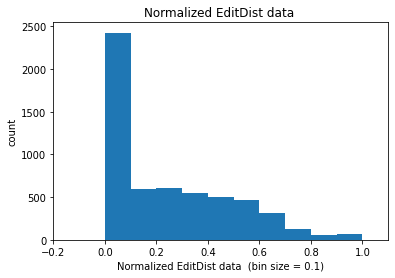

In [ ]:
# fixed bin size
bins = np.arange(0, 1.1, 0.1) # fixed bin size
data=np.array(list_dist)
plt.xlim([min(data)-0.1, max(data)+0.1])

plt.hist(data, bins=bins, alpha=1)
plt.title('Normalized EditDist data ')
plt.xlabel('Normalized EditDist data  (bin size = 0.1)')
plt.ylabel('count')

plt.show()

#Calculate Average Cosine Similarity 
Within & Across speakers

#Extract word pairs for evaluation

* Different occurrences of the same spoken by the same speaker
* Same word spoken by different speakers
* Different words spoken by the same speaker


In [ ]:
speakers=torch.load(speakers_file)
_speakers_=np.array(speakers)
speaker_ids = np.unique(speakers)
_words_=np.array(words)

min_len = 1

#exract words spoken by the same speaker multiple times
print('All words extracted must have at least', min_len, 'character(s)' )
print('extracting occurrences of the same word spoken by the same speaker ...')
same_speaker_same_words=[]
w_list_1={}
for sid in speaker_ids:
  idx=np.where(_speakers_ == sid)[0]
  s_words = _words_[idx]
  s_vocab=np.unique(s_words)
  for word in s_vocab :
    if len(word)>=min_len:
     sub_idx=np.where(s_words == word)[0]
     if len(sub_idx) >= 2 :
       #sub_idx=np.random.choice(sub_idx, size=2, replace=False)
       same_speaker_same_words.append(idx[sub_idx])
       w_list_1[word]=1

#check
print('number of words:', len(same_speaker_same_words))
i=randint(0,len(same_speaker_same_words))
print('example:')
print(_words_[same_speaker_same_words[i]])
print(_speakers_[same_speaker_same_words[i]])


#exract occurrences of same word spoken by different speakers
print('\nextracting occurrences of the same word spoken by different speakers ...')
diff_speaker_same_words=[]
w_list_2={}
for word in vocab:
  if len(word)>=min_len:
   idx=np.where(_words_ == word)[0]
   w_speakers = _speakers_[idx]
   s_ids=np.unique(w_speakers)
   if len(s_ids) >= 2 :
      temp={}
      for _i in idx:
        temp[speakers[_i]]=_i
      sub_idx=list(temp.values())
      #sub_idx=np.random.choice(sub_idx, size=2, replace=False)
      diff_speaker_same_words.append(sub_idx)
      w_list_2[word]=1

#check
print('number of words:', len(diff_speaker_same_words))
i=randint(0,len(diff_speaker_same_words))
print('example:')
print(_words_[diff_speaker_same_words[i]])
print(_speakers_[diff_speaker_same_words[i]])


print('\nextracting lists of different words spoken by the same speaker ...')
same_speaker_diff_words=[]
for sid in speaker_ids:
  idx=np.where(_speakers_ == sid)[0]
  s_words = _words_[idx]
  s_vocab=np.unique(s_words)
  final_idx={}
  for _i in idx:
    if len(words[_i]) >=min_len:
      final_idx[words[_i]] = _i
  same_speaker_diff_words.append(list(final_idx.values()))


All words extracted must have at least 1 character(s)
extracting occurrences of the same word spoken by the same speaker ...
number of words: 6557
example:
['case' 'case']
['7021' '7021']

extracting occurrences of the same word spoken by different speakers ...
number of words: 3150
example:
['what' 'what' 'what' 'what' 'what' 'what' 'what' 'what' 'what' 'what'
 'what' 'what' 'what' 'what' 'what' 'what' 'what' 'what' 'what' 'what'
 'what' 'what' 'what' 'what' 'what' 'what' 'what' 'what' 'what' 'what'
 'what']
['1188' '121' '1221' '1284' '1320' '1580' '2094' '237' '2830' '2961'
 '3570' '3575' '3729' '4077' '4446' '4507' '4970' '4992' '5105' '5142'
 '5639' '5683' '61' '672' '6829' '6930' '7127' '7176' '8230' '8455' '8463']

extracting lists of different words spoken by the same speaker ...


In [ ]:

def avg_cosine(A):
    A=cosine_similarity(A)
    #sum the off diagonal elements, and divide by 2 (symmetric)
    sum = (A.sum() - np.diag(A).sum())/2 
    n=A.shape[0]
    total = n*(n-1)/2
    return sum/total

_embeddings_=np.array(trained_embs)

sum=0
total=0
for i in range(len(same_speaker_diff_words)):
   sum+=avg_cosine(_embeddings_[same_speaker_diff_words[i]])
   total+=1
print('Average cosine similarity between different words spoken by the same speaker',sum/total)
print('total', total)
sum=0
total=0
for i in range(len(same_speaker_same_words)):
   w=words[same_speaker_same_words[i][0]]
   score=avg_cosine(_embeddings_[same_speaker_same_words[i]])
   sum+=score
   total+=1
print('Average cosine sim between the same word spoken by the same speaker', sum/total)
print('total', total)

sum=0
total=0
for i in range(len(diff_speaker_same_words)):
   w=words[diff_speaker_same_words[i][0]]
   sum+=avg_cosine(_embeddings_[diff_speaker_same_words[i]])
   total+=1
print('Average cosine sim between the same word spoken by different speakers', sum/total)

print('total', total)

Average cosine similarity between different words spoken by the same speaker 0.2443605595510198
total 40
Average cosine sim between the same word spoken by the same speaker 0.760017156577129
total 6557
Average cosine sim between the same word spoken by different speakers 0.7772085086772136
total 3150


In [ ]:
def contain_same_chars(w1, w2):
  return distance(sorted(w1),sorted(w2))<1
np.random.seed(2244)
within_ABX=[]
for i in range(len(same_speaker_same_words)):
   w=words[same_speaker_same_words[i][0]]
   sid1=speakers[same_speaker_same_words[i][0]]
   if len(w) >= 5:
     #pick two words, these will be A and X
     AX=np.random.choice(same_speaker_same_words[i], size=2, replace=False)
     #find a word by the same speaker, len 5, but has editDist =1 
     for j in range(len(same_speaker_diff_words)):
       sid2=speakers[same_speaker_diff_words[j][0]]
       if sid2 == sid1:
         for k in range(len(same_speaker_diff_words[j])):
           w2=words[same_speaker_diff_words[j][k]]
           if len(w)== len(w2):
             if distance(w, w2)>0 and distance(w, w2)<=2:
               B=same_speaker_diff_words[j][k]
               within_ABX.append([AX[0], B, AX[1]])
             elif distance(w, w2)>2 and contain_same_chars(w, w2):
               B=same_speaker_diff_words[j][k]


print(len(within_ABX))

across_ABX=[]
for i in range(len(diff_speaker_same_words)):
   w=words[diff_speaker_same_words[i][0]]
   if len(w) >= 5:
     ss=0
     while ss < len(diff_speaker_same_words[i])-1:
      #pick two words, these will be A and X
      A=diff_speaker_same_words[i][ss]
      X=diff_speaker_same_words[i][ss+1]
      sid1=speakers[A]
      #find a word by the same speaker, A, len 5, but has editDist =1
      for j in range(len(same_speaker_diff_words)):
         sid2=speakers[same_speaker_diff_words[j][0]]
         if sid2 == sid1:
           for k in range(len(same_speaker_diff_words[j])):
             w2=words[same_speaker_diff_words[j][k]]
             if len(w)== len(w2):
               if distance(w, w2)>0 and distance(w, w2)<=2:
                 B=same_speaker_diff_words[j][k]
                 across_ABX.append([A, B, X])
               elif distance(w, w2)>2 and contain_same_chars(w, w2):
                 B=same_speaker_diff_words[j][k]
      ss+=2
          
print(len(across_ABX))
for i in random.sample(range(0, len(within_ABX)), 10):
   print(_words_[within_ABX[i]])
   print(_speakers_[within_ABX[i]])


     
speaker_ABX=[]
for i in range(len(diff_speaker_same_words)):
   w=words[diff_speaker_same_words[i][0]]
   if len(w) >= 5:
     ss=0
     while ss < len(diff_speaker_same_words[i])-1:
      #pick two words, these will be A and X
      A=diff_speaker_same_words[i][ss]
      B=diff_speaker_same_words[i][ss+1]
      sid1=speakers[A]
      #find a word by the same speaker, A, len 5, but has editDist =1
      for j in range(len(same_speaker_diff_words)):
         sid2=speakers[same_speaker_diff_words[j][0]]
         if sid2 == sid1:
           for k in range(len(same_speaker_diff_words[j])):
             w2=words[same_speaker_diff_words[j][k]]
             if len(w)== len(w2):
               if distance(w, w2)>0 and distance(w, w2)<=2:
                 X=same_speaker_diff_words[j][k]
                 speaker_ABX.append([A, B, X])
      ss+=2
                  
print(len(speaker_ABX))
for i in random.sample(range(0, len(speaker_ABX)), 10):
   print(_words_[speaker_ABX[i]])
   print(_speakers_[speaker_ABX[i]])



2244
3149
['their' 'there' 'their']
['4507' '4507' '4507']
['could' 'found' 'could']
['1580' '1580' '1580']
['shone' 'shine' 'shone']
['672' '672' '672']
['could' 'bound' 'could']
['7729' '7729' '7729']
['stood' 'shook' 'stood']
['6829' '6829' '6829']
['sleep' 'steed' 'sleep']
['908' '908' '908']
['their' 'these' 'their']
['3570' '3570' '3570']
['tears' 'heard' 'tears']
['908' '908' '908']
['which' 'while' 'which']
['8230' '8230' '8230']
['under' 'order' 'under']
['3729' '3729' '3729']
3149
['little' 'little' 'kettle']
['1284' '1320' '1284']
['caused' 'caused' 'raised']
['121' '1221' '121']
['expression' 'expression' 'impression']
['1320' '1580' '1320']
['scale' 'scale' 'style']
['3570' '7729' '3570']
['round' 'round' 'would']
['672' '7021' '672']
['listen' 'listen' 'mister']
['1580' '2961' '1580']
['those' 'those' 'shone']
['1221' '1284' '1221']
['drawn' 'drawn' 'draws']
['1188' '1221' '1188']
['south' 'south' 'north']
['1320' '1995' '1320']
['house' 'house' 'whose']
['5639' '61' '563

In [ ]:
from scipy import spatial
correct=0
_embeddings_=np.array(trained_embs)

for i in range(len(within_ABX)):
  embs=_embeddings_[within_ABX[i]]
  c1=1 - spatial.distance.cosine(embs[2],embs[0])
  c2=1 - spatial.distance.cosine(embs[2],embs[1])
  if c1>c2:
    correct+=1
print('ABX error rate within speakers: ', 1-(correct/len(within_ABX)))

correct=0
for i in range(len(across_ABX)):
  embs=_embeddings_[across_ABX[i]]
  c1=1 - spatial.distance.cosine(embs[2],embs[0])
  c2=1 - spatial.distance.cosine(embs[2],embs[1])
  if c1>c2:
    correct+=1
print('ABX error rate across speakers: ', 1-(correct/len(across_ABX)))


correct=0
for i in range(len(speaker_ABX)):
  embs=_embeddings_[speaker_ABX[i]]
  c1=1 - spatial.distance.cosine(embs[2],embs[0])
  c2=1 - spatial.distance.cosine(embs[2],embs[1])
  if c1>c2:
    correct+=1
print('speaker ABX error rate: ', 1-(correct/len(across_ABX)))



ABX error rate within speakers:  0.03832442067736186
ABX error rate across speakers:  0.04572880279453795
speaker ABX error rate:  0.42203874245792317
